In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('Open_AI')

In [ ]:
# Define Tools
# import os
from typing import Annotated, TypedDict, Union, Literal, List, Dict, Any
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage, RemoveMessage
# from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolExecutor, ToolInvocation,ToolNode, tools_condition

# Define custom mathematical functions
@tool
def plus(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b
@tool
def subtract(a: float, b: float) -> float:
    """Subtract two numbers."""
    return a - b
@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b
@tool
def divide(a: float, b: float) -> float:
    """Divide two numbers, with error handling for division by zero."""
    if b == 0:
        return "Error: Division by zero is not allowed."
    return a / b

tools = [plus, subtract, multiply, divide]

In [ ]:
# Define the system prompt
system_prompt = """
You are a helpful assistant that can answer general questions and perform mathematical operations.
When you identify a mathematical query that requires addition, subtraction, multiplication, or division,
you should call the appropriate function instead of calculating it yourself.

For mathematical operations, use these available tools:
- plus: For adding two numbers (e.g., "What is 5 plus 3?","what is 2+1?")
- subtract: For subtracting two numbers (e.g., "Calculate 10 minus 7","what is 3-5?")
- multiply: For multiplying two numbers (e.g., "Multiply 6 by 4","what is 2*1?")
- divide: For dividing two numbers (e.g., "Divide 20 by 5","what is 6/3?")

IMPORTANT:
1. For general, non-mathematical questions (like "What is AI?" or "What is a dental cavity?"), answer directly without using any tool calls.
2. Only use mathematical tools for explicit calculations involving addition, subtraction, multiplication, or division.
3. When answering directly, do NOT include any tool_calls in your response.
4. Mathematical queries must be explicit calculations with specific numbers.
"""

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_openai import ChatOpenAI

# Initialize the graph builder with the defined state
graph_builder = StateGraph(State)

# Initialize the LLM (GPT-4) and bind the tools to it
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# System message to guide the agent's behavior
SYS_MSG = SystemMessage(content=system_prompt)

In [ ]:
def tools_condition(state: State) -> str:
    """Determine if we should use tools or provide a direct response."""
    messages = state["messages"]
    last_message = messages[-1]

    # Check if the last message contains a tool_calls field indicating the LLM wants to use tools
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

In [ ]:
def chatbot(state: State):
    """Process the human message and decide what to do next."""
    messages = state["messages"]
    system_message = SystemMessage(content=system_prompt)

    # Prepend the system message to ensure the LLM has context
    all_messages = [system_message] + messages

    # Get response from the LLM
    response = llm_with_tools.invoke(all_messages)

    # Return updated messages
    return {"messages": messages + [response]}

In [ ]:
# Build the graph
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot", chatbot)

# Add a node for executing tools
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add conditional edges: the chatbot decides whether to use tools or end the conversation
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)

# After using a tool, return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Set the chatbot as the entry point of the graph
graph_builder.set_entry_point("chatbot")

# Compile the graph into a runnable agent
mathematical_agent = graph_builder.compile()

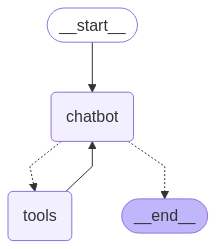

In [ ]:
mathematical_agent


In [ ]:
from IPython.display import Markdown, display
def call_agent(agent, prompt, user_config={"configurable": {"thread_id": "any"}}):
    events = agent.stream(
        {"messages": [HumanMessage(content=prompt)]},  # Properly format as HumanMessage
        user_config,
        stream_mode="values",
    )

    final_event = None
    for event in events:
        if "messages" in event and event["messages"]:
            event["messages"][-1].pretty_print()
            final_event = event

    if final_event:
        display(Markdown(final_event["messages"][-1].content))

In [ ]:
query = 'what is 2*5?'
call_agent(mathematical_agent, query)

================================ Human Message =================================

what is 2*5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ztTR33Zc4tZZZ75ylcoAZLEI)
 Call ID: call_ztTR33Zc4tZZZ75ylcoAZLEI
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10.0
================================== Ai Message ==================================

The result of 2 multiplied by 5 is 10.


The result of 2 multiplied by 5 is 10.

In [ ]:
query = 'what is AI?'
call_agent(mathematical_agent, query)

================================ Human Message =================================

what is AI?
================================== Ai Message ==================================

AI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. It encompasses a variety of technologies and methods, including machine learning, natural language processing, robotics, and computer vision, enabling machines to perform tasks that typically require human intelligence, such as understanding language, recognizing patterns, solving problems, and making decisions. AI can be categorized into narrow AI, which is designed for specific tasks, and general AI, which aims to perform any intellectual task that a human can do.


AI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. It encompasses a variety of technologies and methods, including machine learning, natural language processing, robotics, and computer vision, enabling machines to perform tasks that typically require human intelligence, such as understanding language, recognizing patterns, solving problems, and making decisions. AI can be categorized into narrow AI, which is designed for specific tasks, and general AI, which aims to perform any intellectual task that a human can do.

In [ ]:
query = 'what is the dental cavity?'
call_agent(mathematical_agent, query)

================================ Human Message =================================

what is the dental cavity?
================================== Ai Message ==================================

A dental cavity, also known as tooth decay or caries, is a damaged area in the hard surface of a tooth that develops into tiny openings or holes. Cavities are caused by a combination of factors, including bacteria in the mouth, frequent snacking, sugary drinks, and inadequate oral hygiene. When bacteria in the mouth break down sugars, they produce acids that can erode the tooth enamel, leading to decay. If left untreated, cavities can cause pain, infection, and even tooth loss. Regular dental check-ups and good oral hygiene practices, such as brushing and flossing, can help prevent cavities.


A dental cavity, also known as tooth decay or caries, is a damaged area in the hard surface of a tooth that develops into tiny openings or holes. Cavities are caused by a combination of factors, including bacteria in the mouth, frequent snacking, sugary drinks, and inadequate oral hygiene. When bacteria in the mouth break down sugars, they produce acids that can erode the tooth enamel, leading to decay. If left untreated, cavities can cause pain, infection, and even tooth loss. Regular dental check-ups and good oral hygiene practices, such as brushing and flossing, can help prevent cavities.

In [ ]:
query = 'what is the gut bacteria?'
call_agent(mathematical_agent, query)

================================ Human Message =================================

what is the gut bacteria?
================================== Ai Message ==================================

Gut bacteria, also known as gut microbiota, are the microorganisms that live in your digestive tract.  They play a crucial role in digestion, immunity, and overall health.  A diverse and balanced gut microbiome is generally associated with better health outcomes.


Gut bacteria, also known as gut microbiota, are the microorganisms that live in your digestive tract.  They play a crucial role in digestion, immunity, and overall health.  A diverse and balanced gut microbiome is generally associated with better health outcomes.
